In [1]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer, confusion_matrix
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline, SelectTailK, LeaveTailK, SelectK2Last, DummyRegressor
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
from anrg.classified_regression import ClassifiedRegressor
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [2]:
trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
# trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [3]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_comb = trn.groupby('Id').agg(['mean','std','median','count', 'min', 'max'])
trn_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_comb.columns.values)]
# ignore id's where all Ref vales are NaN
trn_withRef_comb = trn_comb[pd.notnull(trn_comb.Ref_mean)]
# Gargage collection
del trn
del trn_comb
# Timing
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 12.0375 secs


In [4]:
# Add deterministic estimator as columns
# MP params=0.82
trn_withRef_comb.loc[:,'MP'] = 1+pow(pow(10, trn_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82)
#KDP
kdp_aa, kdp_bb, kdp_aa_scaling, kdp_bb_scaling = 4.06, 0.0866, 0.33, 0.79
trn_withRef_comb.loc[:,'KDP'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdp_aa*kdp_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdp_bb*kdp_bb_scaling)
#KDP_ZDR
kdpzdr_aa, kdpzdr_bb, kdpzdr_cc, kdpzdr_aa_scaling = 13.6, 0.0968, -0.286, 0.003
trn_withRef_comb.loc[:, 'KDP_ZDR'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdpzdr_aa*kdpzdr_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdpzdr_bb)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),kdpzdr_cc)
#REF_ZDR
refzdr_aa, refzdr_bb, refzdr_cc, refzdr_aa_scaling, refzdr_bb_scaling, refzdr_cc_scaling = 0.00746, 0.945, -4.76, 0.0017, 0.9, 0.8
trn_withRef_comb.loc[:,'REF_ZDR'] = (refzdr_aa*refzdr_aa_scaling)*pow(pow(10,trn_withRef_comb['Ref_mean']/10),refzdr_bb*refzdr_bb_scaling)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),refzdr_cc*refzdr_cc_scaling)
# Regularizing negative predictions to 0
for name in ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']:
    trn_withRef_comb.loc[trn_withRef_comb[name]<0, name] = 0
# Taking log(1+x) on all predictions
trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']] = np.log10(1+trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']])

In [5]:
# Extract X and y
y = trn_withRef_comb['Expected_mean']
X = trn_withRef_comb.ix[:, [col for col in trn_withRef_comb.columns if not 'Expected' in col]]  # NOTE: used range slicing on column
# Garbage collection
del trn_withRef_comb
print X.shape, y.shape

(731556, 136) (731556,)


In [6]:
lpo = LogPlusOne()
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
def LogPlusOne_score(ground_truth, predictions):
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=False)  # define scoring metric

In [7]:
reg_sub = [None, None]
for i in [0, 1]:
    base1 = Pipeline([('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=7))])  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
    base2 = Pipeline([('sel', LeaveTailK(K=4)), ('xgb', xgb.sklearn.XGBRegressor(n_estimators=500, nthread=7))], copy = False)
    base3 = Pipeline([('sel', LeaveTailK(K=4)), ('ri', Ridge(alpha=2.0))], copy = False)
    base4 = Pipeline([('sel', LeaveTailK(K=4)), ('la', Lasso(alpha=0.01))], copy = False)
    base5 = Pipeline([('sel', SelectK2Last(K=4)), ('mp', DummyRegressor())], copy = False)
    base6 = Pipeline([('sel', SelectK2Last(K=3)), ('kdp', DummyRegressor())], copy = False)
    base7 = Pipeline([('sel', SelectK2Last(K=2)), ('kdp_zdr', DummyRegressor())], copy = False)
    base8 = Pipeline([('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())], copy = False)
    blender = Ridge(alpha=1.45)
    base_models=(base1, base2, base3, base4, base5, base6, base7, base8)
    reg_sub[i] = BlendedRegressor(base_models=base_models, blending_model=blender, blending_split=0.15, with_feature=True)
reg_sub = tuple(reg_sub)

In [8]:
# label at 45, class xgb 500, proba_thresh=0.55
clf = xgb.sklearn.XGBClassifier(n_estimators=500, nthread=7)
reg = ClassifiedRegressor(labeling_thresh=np.log10(1+45) , classifier=clf, proba_thresh=0.55, regressors=reg_sub, verbose=1)
pip = Pipeline([('lpo',lpo), ('imp',imp), ('ss',ss), ('reg',reg)], copy=True)  # a Pipeline wrapper to chain'em up
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=3)
print np.mean(scores), np.std(scores)

[CV] no parameters to be set .........................................
658400 640131 18269  
73156 73069 87  
[CV] .............. no parameters to be set, score=-22.261283 -23.6min
[CV] no parameters to be set .........................................
658400 640143 18257  
73156 73077 79  
[CV] .............. no parameters to be set, score=-22.586572 -24.1min
[CV] no parameters to be set .........................................
658400 640250 18150  
73156 73096 60  
[CV] .............. no parameters to be set, score=-23.167930 -22.1min
[CV] no parameters to be set .........................................
658400 640278 18122  
73156 73093 63  
[CV] .............. no parameters to be set, score=-24.708277 -21.9min
[CV] no parameters to be set .........................................
658400 640227 18173  
73156 73059 97  
[CV] .............. no parameters to be set, score=-23.869468 -20.1min
[CV] no parameters to be set .........................................
658400 640678 17722  
73

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 211.3min finished


In [16]:
# label at 45, class xgb 500, proba_thresh=0.7
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=3)
print np.mean(scores), np.std(scores)

[CV] no parameters to be set .........................................
658400 640131 18269  
73156 72985 171  
[CV] .............. no parameters to be set, score=-22.631968 -20.9min
[CV] no parameters to be set .........................................
658400 640143 18257  
73156 72956 200  
[CV] .............. no parameters to be set, score=-23.287978 -20.6min
[CV] no parameters to be set .........................................
658400 640250 18150  
73156 73021 135  
[CV] .............. no parameters to be set, score=-23.281791 -20.3min
[CV] no parameters to be set .........................................
658400 640278 18122  
73156 73001 155  
[CV] .............. no parameters to be set, score=-24.899633 -20.2min
[CV] no parameters to be set .........................................
658400 640227 18173  
73156 72923 233  
[CV] .............. no parameters to be set, score=-23.805914 -20.3min
[CV] no parameters to be set .........................................
658400 640678 17722

KeyboardInterrupt: 

In [22]:
# label at 45, class xgb 500, proba_thresh=0.67
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=3)
print np.mean(scores), np.std(scores)

[CV] no parameters to be set .........................................
658400 640131 18269  
73156 73009 147  
[CV] .............. no parameters to be set, score=-22.480613 -20.1min
[CV] no parameters to be set .........................................
658400 640143 18257  
73156 72987 169  
[CV] .............. no parameters to be set, score=-23.257660 -20.3min
[CV] no parameters to be set .........................................
658400 640250 18150  
73156 73040 116  
[CV] .............. no parameters to be set, score=-23.219856 -20.0min
[CV] no parameters to be set .........................................
658400 640278 18122  
73156 73024 132  
[CV] .............. no parameters to be set, score=-24.815252 -20.2min
[CV] no parameters to be set .........................................
658400 640227 18173  
73156 72961 195  
[CV] .............. no parameters to be set, score=-23.812373 -20.1min
[CV] no parameters to be set .........................................
658400 640678

KeyboardInterrupt: 

In [13]:
[X_trn, X_val, y_trn, y_val] = train_test_split(X, y, test_size = 0.2)

585244 569119 16125  
146312 146019 293  
1125.89659715
22.113595083


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


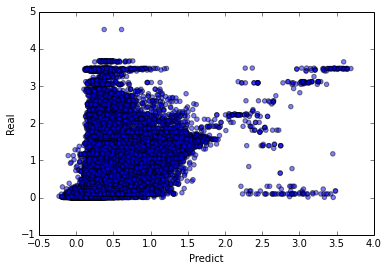

In [14]:
t = time.time()
pip.fit(X_trn, y_trn)
y_val_lpo_predict = pip.predict(X_val)
print time.time()-t
plt.scatter(y_val_lpo_predict, np.log10(1+y_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
print LogPlusOne_score(y_val, y_val_lpo_predict)

In [15]:
pip_sub = Pipeline([('lpo', lpo), ('imp', imp), ('ss', ss), ('clf', pip.steps[3][1].classifier)], copy=True)
y_label_val_predict_prob = pip_sub.predict_proba(X_val)[:, 0]
score = []
param_range = np.arange(0.5, 0.71, 0.01)
for i, th in enumerate(param_range):
    c = confusion_matrix(y_val>45, y_label_val_predict_prob<th)
    pip.steps[3][1].proba_thresh = th    
    TP, FN, TN, FP = c[1,1], c[1,0], c[0,0], c[0,1]
    print "=====th = {}=====(TP {}, FN {}, TN {}, FP {})===score {}".format(th, TP, FN, TN, FP, LogPlusOne_score(y_val, pip.predict(X_val)))

146312 146176 136  
=====th = 0.5=====(TP 115, FN 3915, TN 142261, FP 21)===score 22.2662941406
146312 146169 143  
=====th = 0.51=====(TP 118, FN 3912, TN 142257, FP 25)===score 22.2999521053
146312 146163 149  
=====th = 0.52=====(TP 123, FN 3907, TN 142256, FP 26)===score 22.2670964756
146312 146157 155  
=====th = 0.53=====(TP 126, FN 3904, TN 142253, FP 29)===score 22.2575661207
146312 146146 166  
=====th = 0.54=====(TP 133, FN 3897, TN 142249, FP 33)===score 22.2196284903
146312 146140 172  
=====th = 0.55=====(TP 137, FN 3893, TN 142247, FP 35)===score 22.1957868576
146312 146136 176  
=====th = 0.56=====(TP 140, FN 3890, TN 142246, FP 36)===score 22.1633656417
146312 146130 182  
=====th = 0.57=====(TP 145, FN 3885, TN 142245, FP 37)===score 22.159012414
146312 146123 189  
=====th = 0.58=====(TP 151, FN 3879, TN 142244, FP 38)===score 22.1432143953
146312 146118 194  
=====th = 0.59=====(TP 154, FN 3876, TN 142242, FP 40)===score 22.1312322201
146312 146109 203  
=====th = 0.

In [9]:
pip.fit(X, y)

731556 711401 20155  


Pipeline(copy=True,
     steps=[('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('reg', ClassifiedRegressor(classifier=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,...solver='auto', tol=0.001),
         blending_split=0.15, with_feature=True)),
          verbose=1))])

In [10]:
test = pd.read_csv('../data/test.csv')
test_comb = test.groupby('Id').agg(['mean','std','median','count','min', 'max'])
test_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(test_comb.columns.values)]
test_withRef_comb = test_comb[pd.notnull(test_comb.Ref_mean)]
# Add deterministic estimator as columns
# MP params=0.82
test_withRef_comb.loc[:,'MP'] = 1+pow(pow(10, test_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82)
#KDP
kdp_aa, kdp_bb, kdp_aa_scaling, kdp_bb_scaling = 4.06, 0.0866, 0.33, 0.79
test_withRef_comb.loc[:,'KDP'] = np.sign(test_withRef_comb['Kdp_mean'])*(kdp_aa*kdp_aa_scaling)*pow(np.abs(test_withRef_comb['Kdp_mean']),kdp_bb*kdp_bb_scaling)
#KDP_ZDR
kdpzdr_aa, kdpzdr_bb, kdpzdr_cc, kdpzdr_aa_scaling = 13.6, 0.0968, -0.286, 0.003
test_withRef_comb.loc[:, 'KDP_ZDR'] = np.sign(test_withRef_comb['Kdp_mean'])*(kdpzdr_aa*kdpzdr_aa_scaling)*pow(np.abs(test_withRef_comb['Kdp_mean']),kdpzdr_bb)*pow(pow(10,test_withRef_comb['Zdr_mean']/10),kdpzdr_cc)
#REF_ZDR
refzdr_aa, refzdr_bb, refzdr_cc, refzdr_aa_scaling, refzdr_bb_scaling, refzdr_cc_scaling = 0.00746, 0.945, -4.76, 0.0017, 0.9, 0.8
test_withRef_comb.loc[:,'REF_ZDR'] = (refzdr_aa*refzdr_aa_scaling)*pow(pow(10,test_withRef_comb['Ref_mean']/10),refzdr_bb*refzdr_bb_scaling)*pow(pow(10,test_withRef_comb['Zdr_mean']/10),refzdr_cc*refzdr_cc_scaling)
# Regularizing negative predictions to 0
for name in ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']:
    test_withRef_comb.loc[test_withRef_comb[name]<0, name] = 0
# Taking log(1+x) on all predictions
test_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']] = np.log10(1+test_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']])
test_X = test_withRef_comb.ix[:, [col for col in test_withRef_comb.columns if not 'Expected' in col]]  # NOTE: used range slicing on column
print test_X.shape
test_y_predict = 10**pip.predict(X=test_X)-1

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(426094, 136)
426094 425673 421  


In [11]:
# Ref-samples
test_result_withRef = pd.DataFrame()
test_result_withRef['Id'] = test_withRef_comb.index
test_result_withRef['Expected'] = test_y_predict
# All-samples
test_result = pd.DataFrame()
test_result['Id'] = test['Id'].unique()
# Merge and set Non-Ref samples to -1
test_result = pd.merge(test_result, test_result_withRef, how='left', on=['Id'], sort=True)
test_result.loc[test_result['Expected'].isnull(), 'Expected'] = -1
# Write file
datetime_str = time.strftime('%Y%m%d_%H%M%S')
test_result.to_csv('../data/result_'+datetime_str+'.csv', index=False)
print '../data/result_'+datetime_str+'.csv'

../data/result_20151203_192950.csv
